In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import cv2
import zlib
import numpy as np
import base64
import random
import seaborn as sns

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms, datasets
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from PIL import Image
from torchvision import models
from torchvision.models import ResNet18_Weights

In [2]:
def mask_to_binary(mask_data, height=512, width=512):
    mask = np.frombuffer(mask_data, dtype=np.uint8).reshape(height, width)
    binary_mask = mask != 0  # Przekształcenie wartości pikseli na wartości logiczne
    return binary_mask

In [3]:
df1 = pd.read_csv("../Frame Selection/dataset.csv")
df2 = pd.read_csv("../imagefeedback.csv", delimiter=";")
df3 = pd.read_csv("../image.csv", delimiter=";", on_bad_lines='skip')

# Tu łącze dane z różnych plików, usuwam duplikaty bo się tworzą i usuwam brakujące wartosci w SIDE
df = (pd.merge(df1, df2, left_on='image_id', right_on='IMAGE_ID', how='inner')
        [['image_id', 'segmentation', 'SIDE']]
        .dropna(subset=['SIDE']))

# Dekodowanie i dekompresja kolumny 'segmentation'
df['segmentation'] = df['segmentation'].apply(lambda x: zlib.decompress(base64.b64decode(x)))

# Filtracja segmentacji o rozmiarze równym 262144 (bo pojedycnze wartosci mają inne rozmiary)
df = df[df['segmentation'].apply(len) == 262144]

df = (pd.merge(df, df3, left_on='image_id', right_on='ID', how='inner')
        [['image_id', 'segmentation', 'SIDE', 'PATIENTID', 'STUDY_ID']]
        .drop_duplicates()
        .dropna(subset=['SIDE']))

# Usuwam duplikaty w maskach (bo są dwa duplikaty)
df = df.drop_duplicates(subset='segmentation')

df = df[df['segmentation'].apply(lambda x: isinstance(x, bytes))]
df['segmentation'] = df['segmentation'].apply(mask_to_binary)
df = df.reset_index(drop=True)
df = df.reset_index()

In [4]:
df

,index,image_id,segmentation,SIDE,PATIENTID,STUDY_ID
0,0,131aedfhs6pnf1fvtvp49mjf02x1fl1f22,"[[False, False, False, False, False, False, Fa...",0.0,id014,1.3.46.670589.28.68172260235162120220528134546...
1,1,131aedfhs6pnf1fvtvp49mjf04wc7y5722,"[[False, False, False, False, False, False, Fa...",0.0,id014,1.3.46.670589.28.68172260235162120220528134546...
2,2,131aedfhs6pnf1fvtvp49mjf04y0vtqu22,"[[False, False, False, False, False, False, Fa...",0.0,id014,1.3.46.670589.28.68172260235162120220528134546...
3,3,131aedfhs6pnf1fvtvp49mk5l3qcg5hh22,"[[False, False, False, False, False, False, Fa...",0.0,id013,1.3.46.670589.28.68172260235162120220603125733...
4,4,131aedfhs6pnf1fvtvp49mk5l3ra0gpr22,"[[False, False, False, False, False, False, Fa...",0.0,id013,1.3.46.670589.28.68172260235162120220603125733...
...,...,...,...,...,...,...
883,883,13c2ur549vohc0jat2dvt3xrmw2,"[[False, False, False, False, False, False, Fa...",0.0,xx,1.3.12.2.1107.5.4.9.41057.20180405.111305.6614...
884,884,13c2ur549vohc0jat2dvu3xrxb1,"[[False, False, False, False, False, False, Fa...",1.0,xx,1.3.12.2.1107.5.4.9.41057.20180405.111305.6614...
885,885,13c2ur549vohc0jat2dvu3xs0c1,"[[False, False, False, False, False, False, Fa...",1.0,xx,1.3.12.2.1107.5.4.9.41057.20180405.111305.6614...
886,886,13c2ur549vohc0jat2dvu3xs2y1,"[[False, False, False, False, False, False, Fa...",1.0,xx,1.3.12.2.1107.5.4.9.41057.20180405.111305.6614...


In [5]:
def get_model():
    model = models.resnet18(weights=ResNet18_Weights.DEFAULT)
    for param in model.parameters():
        param.requires_grad = False

    model.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)

    model.avgpool = nn.AdaptiveAvgPool2d(output_size=(1,1))
    model.fc = nn.Sequential(nn.Flatten(),
        nn.Linear(512, 128),
        nn.ReLU(),
        nn.Dropout(0.2),
        nn.Linear(128, 1),
        nn.Sigmoid())
    loss_fn = nn.BCELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr= 1e-3)
    return model.to(device), loss_fn, optimizer

In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model, loss_fn, optimizer = get_model()
model.to(device)
print("")

In [7]:
print(f'CUDA available: {torch.cuda.is_available()}')
if torch.cuda.is_available():
    print(f'CUDA device count: {torch.cuda.device_count()}')
    print(f'CUDA device name: {torch.cuda.get_device_name(0)}')
    print(f"Used device: {device}")

CUDA available: True
CUDA device count: 1
CUDA device name: NVIDIA GeForce RTX 3050 Ti Laptop GPU
Used device: cuda


In [8]:
class CustomDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        mask_array = self.dataframe.iloc[idx]['segmentation']
        label = self.dataframe.iloc[idx]['SIDE']
        mask_image = Image.fromarray(mask_array.astype(np.uint8) * 255).convert("L")
        id = self.dataframe.iloc[idx]['index']
        
        if self.transform:
            mask_tensor = self.transform(mask_image)
        else:
            mask_tensor = transforms.ToTensor()(mask_image)
            
        return mask_tensor, torch.tensor(label, dtype=torch.float32), id

# Transformacje danych
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

Tu chcemy podzielić dataset na podzbiory train oraz test w taki sposób, aby te same zdjęcia znajdowały się zawsze w jednym z tych podzbiorów (niektóre zdjęcia mają kilka masek a są one bardzo podobne) - ten kod jest niedeterministyczny ze względu na "np.random.shuffle(uniq_ids)". Przez to accuracy się wacha od 94 do nawet 99% w zalezności od tego jak się dane ułożą


In [9]:
uniq_ids = df['image_id'].unique()
np.random.shuffle(uniq_ids)
len(uniq_ids)

train_size = int(len(uniq_ids) * 0.8) 
test_size = len(uniq_ids) - train_size

train_ids = uniq_ids[:train_size]
test_ids = uniq_ids[train_size:]

train_df = df[df['image_id'].isin(train_ids)]
test_df = df[df['image_id'].isin(test_ids)]

train_dataset = CustomDataset(train_df, transform=transform)
test_dataset = CustomDataset(test_df, transform=transform)

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [10]:
def train_model(model, train_loader, loss_fn, optimizer, num_epochs=10):

    train_losses = []
    
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        for images, labels, idx in train_loader:
            images, labels = images.to(device), labels.to(device).unsqueeze(1)
            # labels = labels.to(device).unsqueeze(1)
            
            optimizer.zero_grad()
            outputs = model(images)
            loss = loss_fn(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * images.size(0)

        train_loss = train_loss / len(train_loader.dataset)
        train_losses.append(train_loss)
        
        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}")

    return train_losses

In [11]:
train_losses = train_model(model, train_loader, loss_fn, optimizer, num_epochs=10)

Epoch 1/10, Train Loss: 0.3656
Epoch 2/10, Train Loss: 0.1358
Epoch 3/10, Train Loss: 0.1011
Epoch 4/10, Train Loss: 0.1462
Epoch 5/10, Train Loss: 0.0741
Epoch 6/10, Train Loss: 0.0428
Epoch 7/10, Train Loss: 0.0622
Epoch 8/10, Train Loss: 0.0475
Epoch 9/10, Train Loss: 0.0422
Epoch 10/10, Train Loss: 0.0453


In [12]:
def evaluate_model(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    wrong_predicted_idx = []
    with torch.no_grad():
        for images, labels, idx in test_loader:
            images = images.to(device)
            labels = labels.to(device).unsqueeze(1)
            outputs = model(images)
            predicted = (outputs > 0.5).float()
            result = (predicted == labels)
            total += labels.size(0)
            correct += result.sum().item()
            
            for i, res in enumerate(result):
                if not res:
                    wrong_predicted_idx.append(idx[i].item())

    print("correct: ", correct)
    print("total: ",total)
    accuracy = 100 * correct / total
    print(f'Accuracy: {accuracy:.2f}%')
    return wrong_predicted_idx

In [13]:
wrong = evaluate_model(model, test_loader)

correct:  175
total:  181
Accuracy: 96.69%


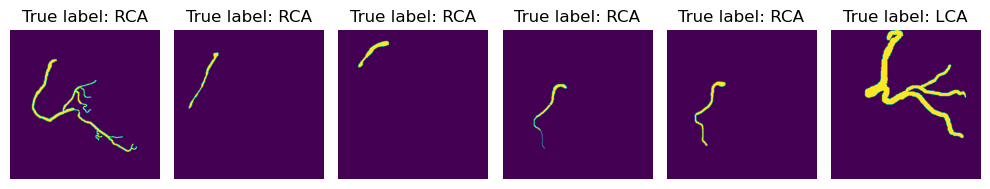

In [15]:
import matplotlib.pyplot as plt

# RCA = 1
# LCA = 0
TP = df['SIDE'].value_counts().get(1.0)
TN = df['SIDE'].value_counts().get(0.0)

def display_wrong_predictions(df, wrong):
    plt.figure(figsize=(10, 10))

    FP = 0
    FN = 0
    for i, val in enumerate(wrong, start=1):
        plt.subplot(1, len(wrong), i)
        plt.imshow(df.loc[val, 'segmentation'])
        plt.axis('off')
        if df.loc[val, 'SIDE'] == 1.0:
            FN += 1
        else:
            FP += 1
        title = "True label: RCA" if df.loc[val, 'SIDE'] == 1.0 else "True label: LCA"
        plt.title(title)

    plt.tight_layout()
    plt.show()
    return FP, FN

FP, FN = display_wrong_predictions(df, wrong)
TP = TP - FN
TN = TN - FP

In [16]:
print("TP: ", TP)
print("TN: ", TN)
print("FP: ", FP)
print("FN: ", FN)

print("suma: ", TP+TN+FP+FN)

TP:  326
TN:  556
FP:  1
FN:  5
suma:  888


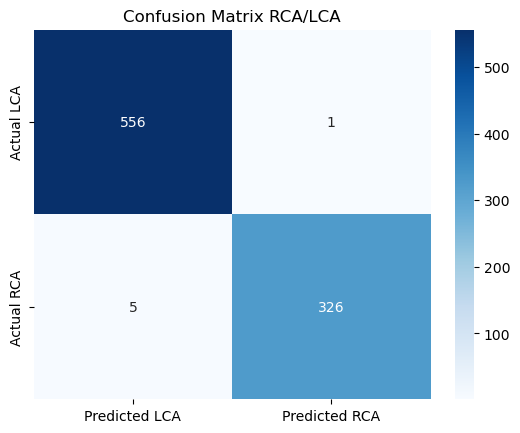

In [17]:
conf_matrix = [[TN, FP],
               [FN, TP]]

# Wyświetlanie confusion matrix za pomocą biblioteki seaborn
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Predicted LCA', 'Predicted RCA'], 
            yticklabels=['Actual LCA', 'Actual RCA'])
plt.title('Confusion Matrix RCA/LCA')
plt.show()

In [18]:
torch.save(model.state_dict(), 'suspicious_model.pth')

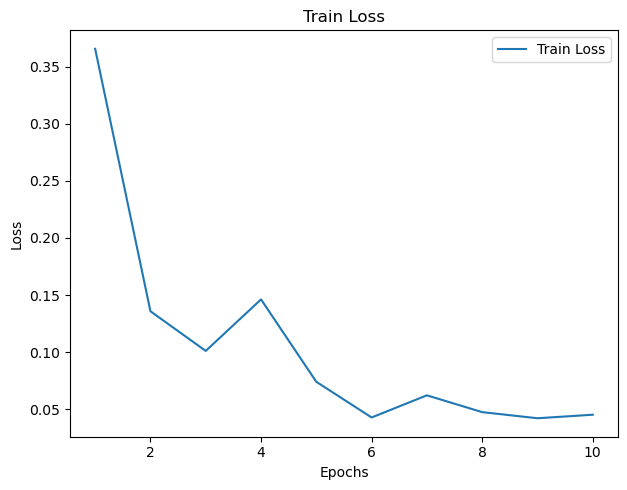

In [19]:
# Rysowanie krzywych uczenia
def plot_learning_curves(train_losses):
    epochs = range(1, len(train_losses) + 1)
    
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label='Train Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Train Loss')

    plt.tight_layout()
    plt.show()

plot_learning_curves(train_losses)